# Solución de la ecuación diferencial parcial de difusión con el método de diferencias finitas.

Este problema nos habla sobre la difusión de un gas radioactivo hacia la atmósfera, asumiendo que el suelo se encuentra en $x=0$ y la atmósfera puede ser $x=\infty$. La ecuación diferencial parcial para este problema es:

\begin{equation}
    \begin{array}{cc}
      \frac{\partial p(x,t)}{\partial t}=D\frac{\partial^2p(x,t)}{\partial x^2}-\lambda p(x,t) & D,\lambda=const
    \end{array}
    \label{eq:PDE}
\end{equation}

Teniendo las siguientes condiciones de borde:

\begin{equation*}
    \begin{array}{cc}
       \frac{\partial p}{\partial x}|_{x=0}=-\chi=const & p(\infty,t)<\infty.
    \end{array}
    %\label{eq:CB}
\end{equation*}

Decidimos no tomar valores infinitamente altos para poder tener valores más controlables, siendo entonces $x_f=Variable$. Para esto, también podremos variar nuestra condición de borde en $p(\infty,t)<\infty$ a una más acorde a nuestro sistema programable, la cual sera $p(x_f,t)=x_f$. manteniendo una esencia de la condición de borde inicial. Por lo tanto, con esto, podremos cambiar nuestras condiciones de borde a las siguientes:

\begin{equation}
    \begin{array}{cc}
       \frac{\partial p}{\partial x}|_{x=0}=-\chi & p(x_f,t)=x_f.
    \end{array}
    \label{eq:CB}
\end{equation}

Teniendo entonces todo lo necesario para resolver numéricamente el problema.

El método numérico que utilizamos para resolver la PDE es diferencias finitas. Las diferencias finitas es un método numérico que utiliza aproximaciones para las derivadas mediante las series de Taylor. Estas aproximaciones funcionan para intervalos muy pequeños en los que pueda ir aproximando los valores para nuestra función. Las diferencias finitas utilizadas son las siguientes:

\begin{equation}
\begin{array}{c}
 \frac{\partial p(x,t)}{\partial t}\approx\frac{p_x^{t}-p_x^{t-1}}{dt}\\
 \frac{\partial^2 p(x,t)}{\partial x^2}\approx\frac{p_{x+1}^t-2p_{x}^t+p_{x-1}^t}{dx^2}
\end{array}
\end{equation}

Estas expresiones, calculadas mediante series de Taylor, son las que posteriormente meteremos dentro de nuestra ecuación diferencial parcial. Para la derivada temporal, usamos BCTS (Backward Central Time Scheme) para poder utilizar el esquema implícito para diferencias finitas. Por otra parte, usamos el esquema central para la segunda derivada espacial. Entonces, podemos reescribir la ec de nuestras parciales como lo siguiente:

\begin{equation}
    p_t=Dp_{xx}-\lambda p 
\end{equation}

Donde $p_t$ es la derivada temporal y $p_{xx}$ es la derivada espacial. Aplicando diferencias finitas a nuestra ecuación nos deja:

\begin{equation}
   \frac{p_x^{t}-p_{x}^{t-1}}{dt}=D\frac{p_{x+1}^t-2p_{x}^t+p_{x-1}^t}{dx^2}-\lambda p_x^t
\end{equation}

También podemos despejar para $p_x^{t-1}$ lo que nos dejara la siguiente expresión:

\begin{equation}
    p_x^{t-1}=-Kp_{x+1}^t+(1+2K+\lambda dt)p_x^{t}-Kp_{x-1}^t \label{eq:FD}
\end{equation}

Donde $K=D\frac{dt}{dx^2}$, lo cual vendría siendo nuestro coeficiente CFL (Courant Friedrichs Lewy). 

In [1]:
%matplotlib nbagg
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from time import time
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=True, figsize=(10, 7))

In [2]:
def tiempo_total(tiempo):
    tiempo_calculado=time()
    tiempo_final=(tiempo_calculado-tiempo)
    if (tiempo_final>3600):
        print('El código tardo %s horas en ejecutarse.' % (tiempo_final/3600))
        print('\n')
    elif (tiempo_final>60):
        print('El código tardo %s minutos en ejecutarse.' % (tiempo_final/60))
        print('\n')
    else:
        print('El código tardo %s segundos en ejecutarse.' % tiempo_final)
        print('\n')

La condición inicial y la condiciones de borde del sistema estan demostrados en la siguiente función. En este caso, escogimos el estado inicial $p(x,0)=0$ y podemos variarlos para distintos resultados. 

Por otra parte, para nuestras condiciones de borde, tenemos lo siguiente:

\begin{equation*}
\begin{array}{c}
    p_x(0,t)=-\chi\\
    p(x,t)=0
\end{array}
\end{equation*}

La condición de Neumann, la de $p_x(0,t)$ no puede ser programa así. Lo que hacemos es aproximarla utilizando diferencias centrales:

\begin{equation*}
    p_x(0,t)\approx\frac{p_1^t-p_{-1}^t}{2dx}=-\chi
\end{equation*}

Entonces, despejaremos para $p_{-1}^t$, lo que nos data:

\begin{equation}
    p_{-1}^t=p_{1}^t+2dx\chi \label{eq:Neumann}
\end{equation}

Ahora, reescribiremos ecuación como si hubiera sido resuelta con FCTS (Forward Central Time Scheme), y obtendremos:

\begin{equation}
    p_x^{t+1}=Kp_{x+1}^t+(1-2K-\lambda dt)p_{x}^{t}-Kp_{x-1}^t \label{eq:FCTS}
\end{equation}

Si utilizamos la ecuación pasada pero con $x=0$, tendremos:

\begin{equation*}
p_{0}^{t+1}=Kp_{1}^t+(1-2K-\lambda dt)p_{0}^{t}-Kp_{-1}^t
\end{equation*}

Entonces, utilizando la ec. para Neumman, tenemos:

\begin{equation*}
    p_{0}^{t-1}=Kp_{1}^t+(1-2K-\lambda dt)p_{0}^{t}+K(p_{1}^t+2dx\chi)
\end{equation*}

Ahora, agrupando términos, tenemos:

\begin{equation}
    p_{0}^{t-1}=(1-2K-\lambda dt)p_{0}^{t}-2Kp_{1}^t+2dx\chi \label{eq:NProg}
\end{equation}

La ecuación pasada es la ecuación que nos ayudara a implementar nuestra condición de Neumann al código.

In [3]:
def CFL(D,dx,dt):
	k=D*(dt/dx**2)
	print("El coeficiente de Courant Friedrichs Lewy (CFL) es",k)
	return k

def CI(x,Ix,t):
    p=np.zeros(Ix)
    for i in range(0,Ix):
        p[i]=0.00
    return p

def BC(xf,k,lam,chi,dx,dt,Ix,t,p):
    p[0]=(1-lam*dt-2*k)*p[0]+2*(k*p[1])+2*(chi*dt)
    p[Ix-1]=xf
    return p

Como usamos el esquema implícito, no hay problema con cumplir un criterio de estabilidad. Podemos definir nuestro sistema de la siguiente forma, para poder resolver nuestra matriz implicita, tenemos que la forma matricial es:

\begin{equation*}
    Ap_x^t=b
\end{equation*}

Donde $b_x=(p_0^{t-1},p_1^{t-1},p_2^{t-1},\cdots,p_x^{t-1})$, mientras que A podriamos considerar la siguiente matriz:

\begin{equation*}
    \begin{array}{c}
         A(i,i-1)=-K  \\
         A(i,i)=1+2K+\lambda dt  \\
         A(i,i+1)=-K
    \end{array}
\end{equation*}

Para cumplir las condiciones de la matriz tridiagonal, necesitamos que $A(0,0)=A(x,x)=1$. Entonces, podemos reescribir la ecuación como:

\begin{equation*}
    \begin{bmatrix}
    A_{0,0} & A_{0,1} & & & 0 \\
    A_{1,0} & A_{1,1} & A_{1,2} & &  \\
    & A_{2,1} & A_{2,2} & \ddots & \\
    & & \ddots & \ddots & A_{x-1,x} \\
    0 & & & A_{x,x-1} & A_{x,x}
    \end{bmatrix} 
    \left.
    \begin{bmatrix}
    p_1^{t} \\
    p_2^{t} \\
    p_3^{t} \\
    \vdots \\
    p_x^{t}
    \end{bmatrix}
    \right. 
    =\begin{bmatrix}
    b_1 \\
    b_2 \\
    b_3 \\
    \vdots \\
    b_x
    \end{bmatrix}
\end{equation*}

Siendo este nuestro sistema de matriz a resolver para poder obtener los valores de $p_x^t$.

In [4]:
def matrizA(Ix,k,dt,lam):
    A=np.zeros((Ix,Ix)) #Comando que genera una matrix de nxn dimensiones.
    A[0,0]=A[Ix-1,Ix-1]=1 #Condiciones de frontera para nuestra matriz.
    
    #Ciclo para generar la matriz de valores A.
    for i in range(1,Ix-1):
        A[i,i-1]=-1*k
        A[i,i]= 1+lam*dt+2*k
        A[i,i+1]=-1*k
    return A

Entonces, ya solo nos queda implementar esto en una matriz solución donde vamos a resolver el sistema de ecuaciones con un comando de Numpy. La función lder es para agregar una expresión extra en nuestra ecuación, pero como no tenemos nada, lo podemos dejar igual a $0$.

In [5]:
def lder(x,Ix,t):
    derecha=np.zeros(Ix)
    return derecha

def metodo_implicito(A,lam,chi,dx,dt,Ix,It,x,t,xf,k,p,lder,BC):

    f1=lder(x,Ix,t)
    #Generamos la matrix b para la solución del problema.
    b=p.copy()
    #Ahora le asignamos valores
    for i in range(1,Ix-1):
        b[i]=b[i]+dt*f1[i]

    #Usamos un comando para solucionar la matrix A*p=b
    p=np.linalg.solve(A,b)
    p=BC(xf,k,lam,chi,dx,dt,Ix,t,p)
    return p

Esta función es el núcleo de nuestro código. En el, colocamos los valores que le daremos al programa. En este caso, los valores son escogidos arbitrariamente.

In [6]:
def Solucion( ):
    tiempo=time()
    D=1.0  #Coeficiente de difusión.
    lam=0.005 #Coeficiente lambda.
    chi=0.5 #Coeficiente chi.
    xf=250   #Metros recorridos por el sistema.
    tf=50   #Segundos simulados.
    
    Ix=101
    It=201
    dx=xf/(Ix-1) #El paso finito de la distancia.
    dt=xf/(It-1) #El paso finito del tiempo.
    x=np.linspace(0,xf,Ix)
    t=np.linspace(0,tf,It)

    k=CFL(D,dx,dt) #El coeficiente CFL
    A=matrizA(Ix,k,dt,lam)
    pSol=np.zeros((Ix,It))
    for j in range(0,It):
        if (j==0):
            p=CI(x,Ix,t)
            p=BC(xf,k,lam,chi,dx,dt,Ix,t,p)
        else:
            p=metodo_implicito(A,lam,chi,dx,dt,Ix,It,x,t[j-1],xf,k,p,lder,BC)
        for i in range(0,Ix):
            pSol[i,j]=p[i]
    graficar=Graf(x,pSol,t,Ix,It)
    tiempo_final=tiempo_total(tiempo)

Ahora, solo debemos gráficar los resultados finales.

In [7]:
def Graf(x,pSol,t,Ix,It):
    fig=plt.figure()
    plt.plot(x,pSol)
    plt.title('Difusion en t={0:.0f}'.format(t[It-1]))
    plt.xlabel('Distancia recorrida.')
    plt.ylabel('Densidad del gas.')
    plt.grid()
    plt.show()

El coeficiente de Courant Friedrichs Lewy (CFL) es 0.2


<IPython.core.display.Javascript object>


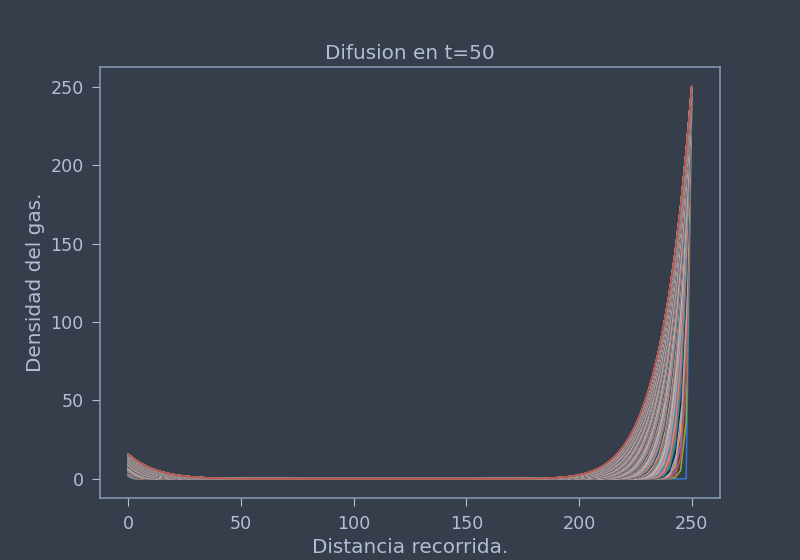

El código tardo 0.4276707172393799 segundos en ejecutarse.




In [8]:
if ( __name__ == '__main__' ):
    grafica=Solucion()

Si queremos observar mejor los resultados, escogemos solamente algunos. Para esto solo modificamos el código de la grafica.

El coeficiente de Courant Friedrichs Lewy (CFL) es 0.2


<IPython.core.display.Javascript object>


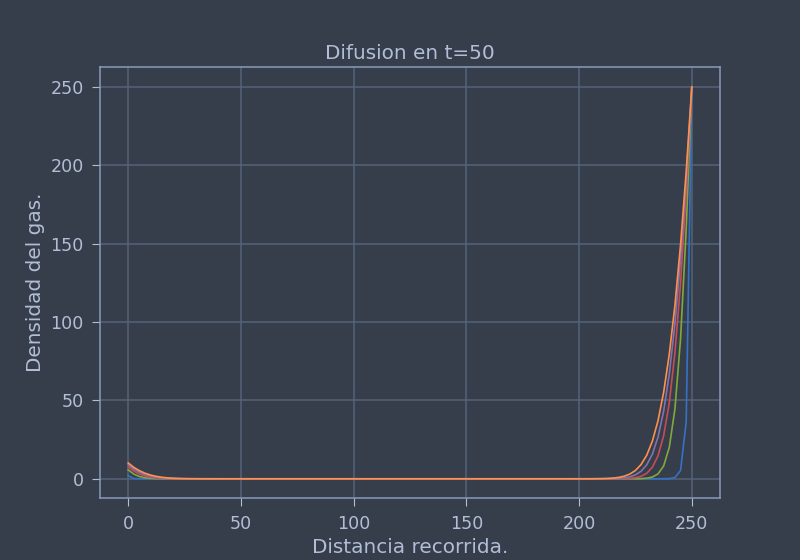

El código tardo 0.22653913497924805 segundos en ejecutarse.




In [9]:
def Graf(x,pSol,t,Ix,It):
    fig=plt.figure()
    plt.plot(x,pSol[:,1])
    plt.plot(x,pSol[:,13])
    plt.plot(x,pSol[:,26])
    plt.plot(x,pSol[:,38])
    plt.plot(x,pSol[:,50])
    plt.title('Difusion en t={0:.0f}'.format(t[It-1]))
    plt.xlabel('Distancia recorrida.')
    plt.ylabel('Densidad del gas.')
    plt.show()
if ( __name__ == '__main__' ):
    grafica=Solucion()

Ahora, le daremos a nuestro sistema un estado inicial $p(x,0)=3x-2$, lo que nos deja con los siguientes resultados:

El coeficiente de Courant Friedrichs Lewy (CFL) es 0.2


<IPython.core.display.Javascript object>


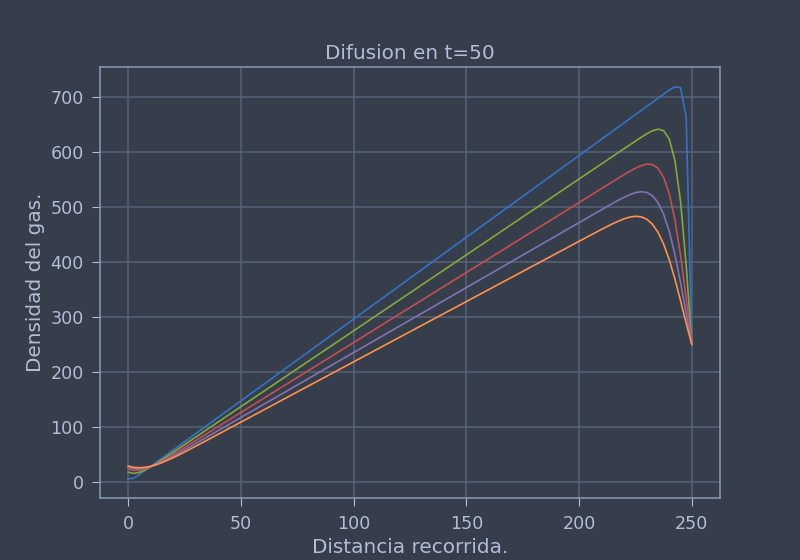

El código tardo 0.3941922187805176 segundos en ejecutarse.




In [10]:
def CI(x,Ix,t):
    p=np.zeros(Ix)
    for i in range(0,Ix):
        p[i]=3*x[i]-2
    return p

if ( __name__ == '__main__' ):
    grafica=Solucion()